# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [142]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline

Прочитаем исходные данные:

In [143]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

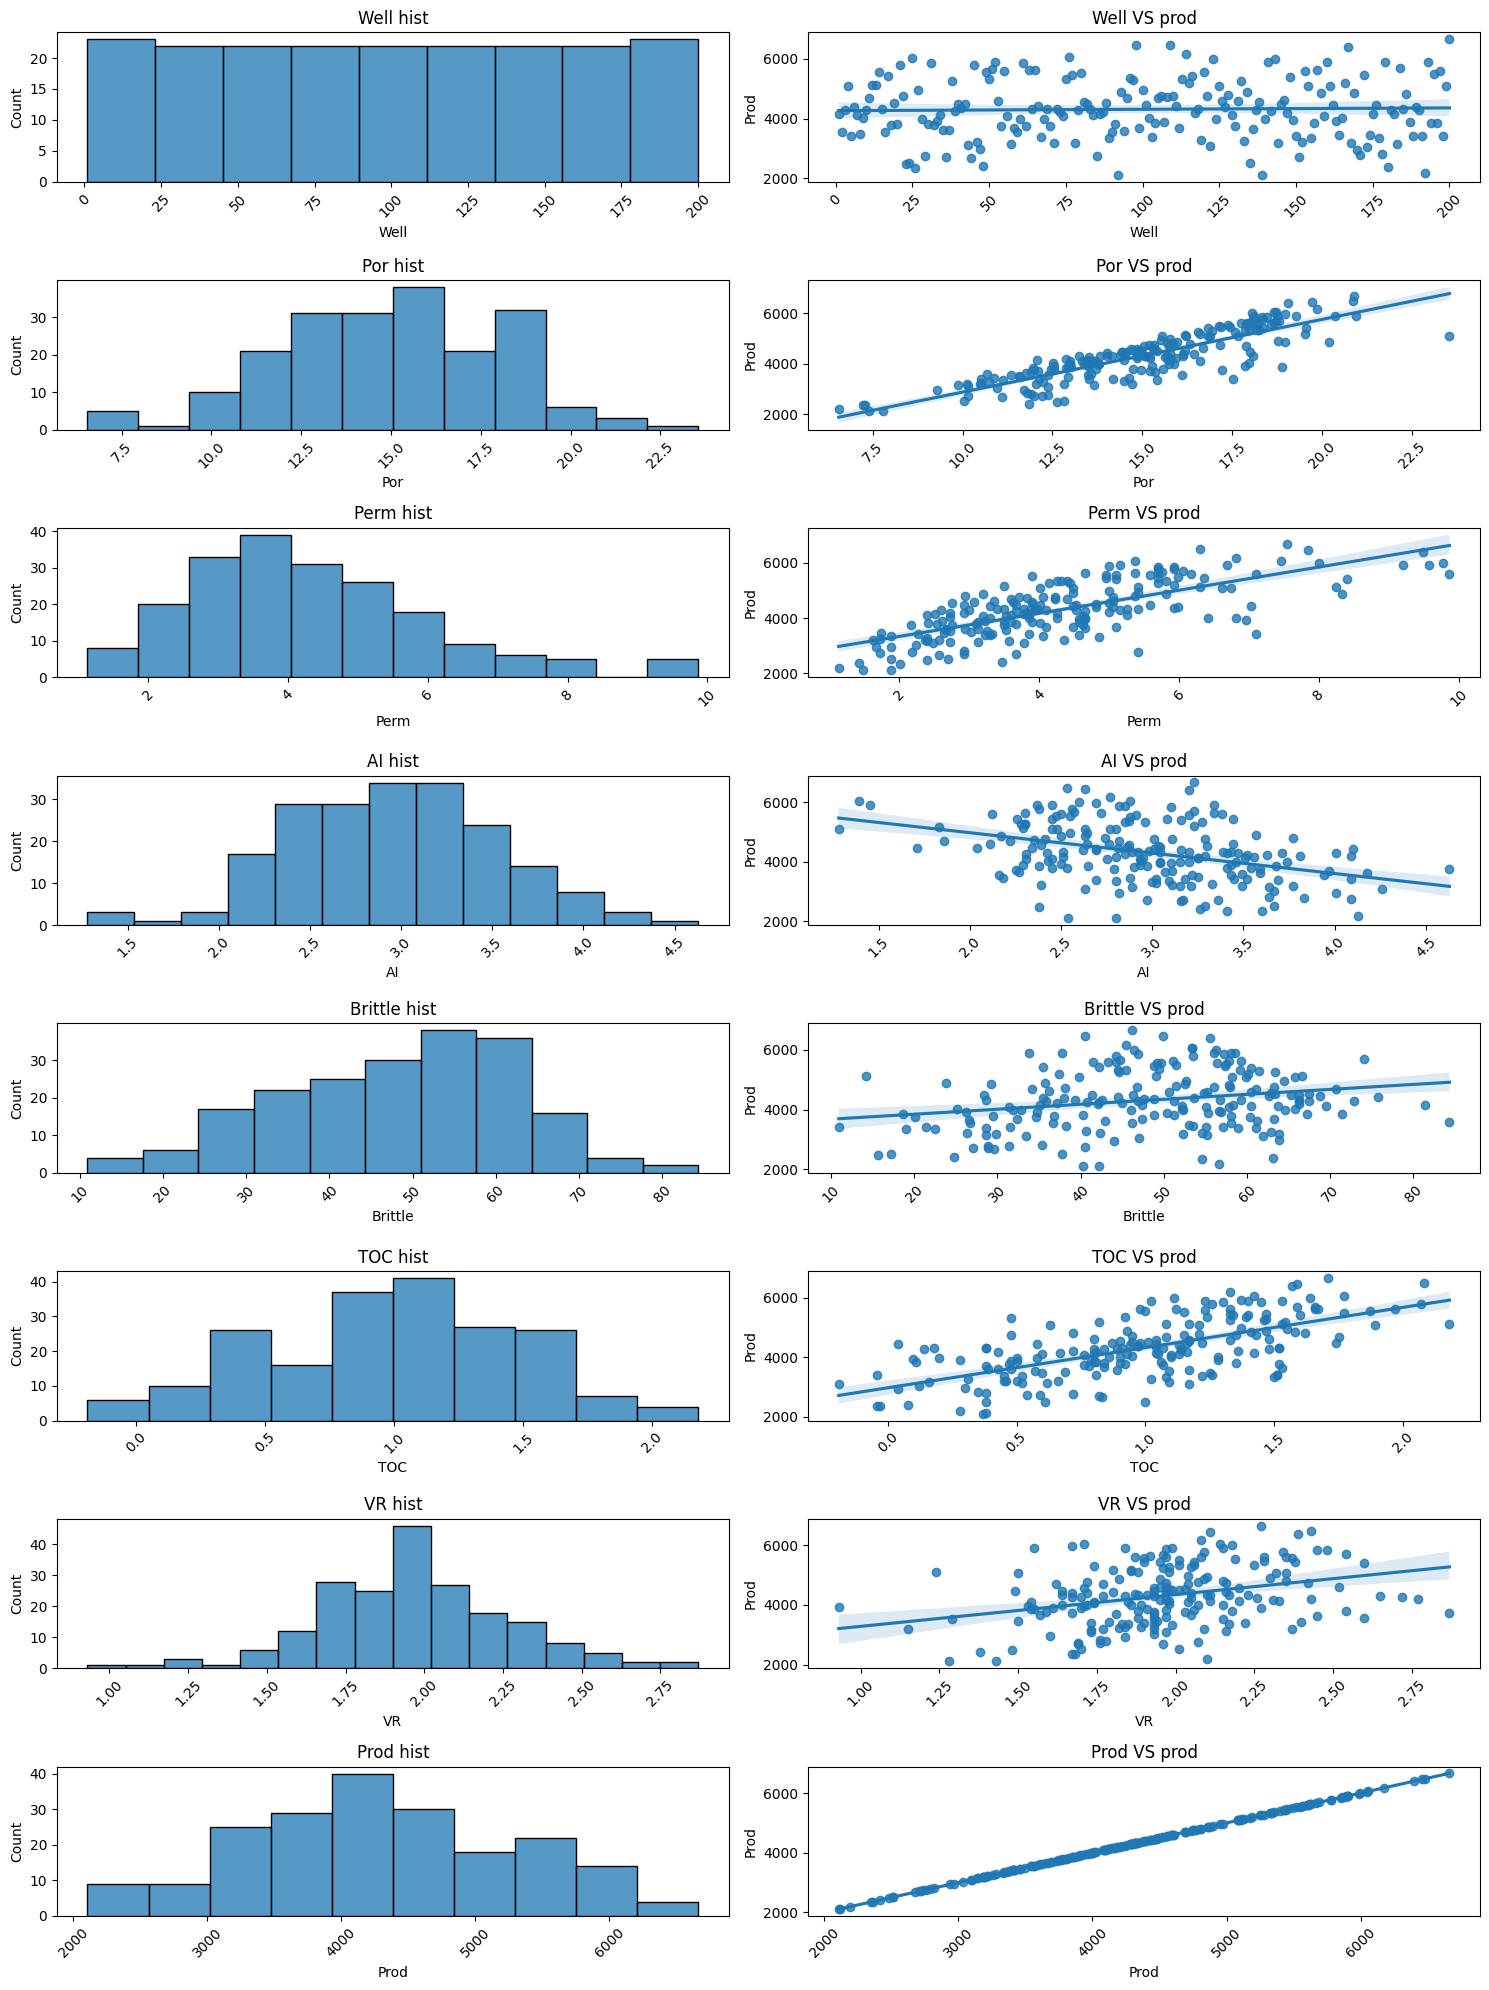

In [144]:
# Ваш код здесь
#Создаем копию данных для облегчения работы с изменениями в таблице
temp_data = data.copy()
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='Prod', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS prod'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Вывод: у признаков пористость скважины, акустический импеданс, коэффициент отражения витринита и у целевого признака добыча газа в сутки распределение имеет куполообразный или близкий к нему вид, значит у признаков нормальное распределение. Наибольшую зависимостб целевой признак имеет с признаком пористость скважины.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Ранг матрицы: 8
Определитель матрицы: 0.0007299388072652095


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


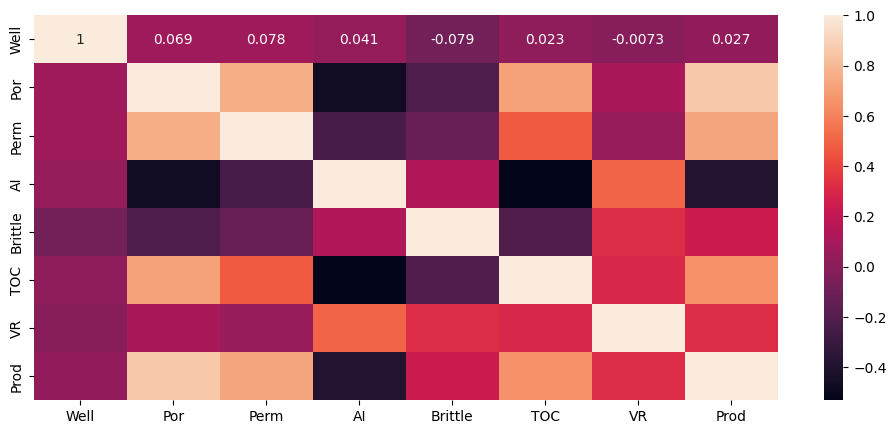

In [145]:
# Ваш код здесь
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(data[num_features].corr(), annot=True);
C = data.corr()
print('Ранг матрицы: {}'.format(np.linalg.matrix_rank(C)))
print('Определитель матрицы: {}'.format(np.linalg.det(C)))
display(C)

Выводы: 
- Наибольшую корреляцию с целевой переменной имеет признак пористость скважины, далее идут признаки проницаемость скважины и общий органический углерод. Практически отсутствует корреляция с признаком акустический импеданс.
- Матрица является плохо обусловленной, так как её определитель близок к нулю.
- У целевого признака наблюдается близкая к мультиколлинеарности ситуация с признаком пористость скважины (коэф. 0.86), а также наблюдается сильная зависимость между признаками пористость скважины и проницаемость скважины (коэф. 0.76).
- В данном случае можно построить модель линейной регрессии по методу наименьших квадратов, но может присутствовать мультиколлинеарность признаков, так как матрица близка к вырожденной.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [146]:
# Ваш код здесь
# составляем матрицу X и вектор целевой переменной
X = np.column_stack((np.ones(200), data.drop('Prod', axis=1)))
y = data[['Prod']]
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X.T@X)@X.T@y
print('w_0', np.round(w_hat.values[0]))
print('w_well', np.round(w_hat.values[1]))
print('w_por', np.round(w_hat.values[2]))
print('w_perm', np.round(w_hat.values[3]))
print('w_ai', np.round(w_hat.values[4]))
print('w_brittle', np.round(w_hat.values[5]))
print('w_toc', np.round(w_hat.values[6]))
print('w_vr', np.round(w_hat.values[7]))
w_hat

w_0 [-1232.]
w_well [0.]
w_por [230.]
w_perm [116.]
w_ai [-365.]
w_brittle [25.]
w_toc [-78.]
w_vr [785.]


,Prod
0,-1232.308030
1,0.050700
2,230.179140
3,116.239006
4,-365.202301
5,24.994370
6,-78.400929
7,785.259815


Выводы: 
- Согласно получившимся коэффициентам признак идентификатор скважины не оказывает влияния на целевой признак, а признаки с отрицательными значениями, такие как акустический импеданс общий органический углерод оказывают обратное влияние на целевой признак.
- Коэффициент w_perm проницаемость скважины равен 230, значит если проницаемость скважины изменится на 1, то производительность увеличится на 230 млн. куб футов. Коэффициент w_toc общего органического углерода равен -78, значит при изменении уровня общего органического углерода на 1%, производительность уменьшится на 78 млн. куб футов.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [147]:
# Ваш код здесь
from sklearn import metrics #метрики
# а) добавились новые данные:
Well = 106.0
Por = 15.32
Perm = 3.71
AI = 3.29
Brittle = 55.99
TOC = 1.35
VR = 2.42
# делаем прогноз выроботки газа
pred_prod = w_hat.iloc[0]+w_hat.iloc[1]*Well+w_hat.iloc[2]*Por+w_hat.iloc[3]*Perm+w_hat.iloc[4]*AI+w_hat.iloc[5]*Brittle+w_hat.iloc[6]*TOC+w_hat.iloc[7]*VR
print('Прогноз модели по формуле МНК на новых данных:', pred_prod.values)

# Прогноз на Python
X = data.drop('Prod', axis=1)
y = data['Prod']
X_new = np.array([[106.0, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42]])
from sklearn.linear_model import LinearRegression
# создаём модель линейной регрессии
model = LinearRegression()
# вычисляем коэффициенты регрессии
model.fit(X, y)
new_prediction = model.predict(X_new)
print('Прогноз с помощью Python на новых данных:', new_prediction)
print('MAE на новых данных: {:.3f}'.format(metrics.mean_absolute_error([4748.315024], new_prediction)))
print('MAPE {:.2f}%'.format(mean_absolute_percentage_error([4748.315024], new_prediction)*100))

# б) считаем предсказание на всех данных
X = np.column_stack((np.ones(200), data.drop('Prod', axis=1)))
y = data[['Prod']]
gen_pred = np.dot(X, w_hat)
print('MAE на всех данных: {:.3f}'.format(metrics.mean_absolute_error(y, gen_pred)))
print('MAPE {:.2f}%'.format(mean_absolute_percentage_error(y, gen_pred)*100))

Прогноз модели по формуле МНК на новых данных: [4723.06405371]
Прогноз с помощью Python на новых данных: [4723.06405371]
MAE на новых данных: 25.251
MAPE 0.53%
MAE на всех данных: 153.623
MAPE 3.63%


Выводы: абсолютная ошибка на всех данных равна 153.623, а поскольку диапазон возможных значений целевой переменной это 2к-6к, то такую ошибку можно считать небольшой, а значит прогноз не слишком сильно разнится с реальным числом.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [148]:
# Ваш код здесь
# выведем навания признаков и значения коэффициентов
print('Корреляция с целевым признаком')
print(C['Prod'])
print('---------')
print('Коэффициенты модели')
print('w_well', np.round(w_hat.values[1]))
print('w_por', np.round(w_hat.values[2]))
print('w_perm', np.round(w_hat.values[3]))
print('w_ai', np.round(w_hat.values[4]))
print('w_brittle', np.round(w_hat.values[5]))
print('w_toc', np.round(w_hat.values[6]))
print('w_vr', np.round(w_hat.values[7]))

Корреляция с целевым признаком
Well       0.026817
Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Prod       1.000000
Name: Prod, dtype: float64
---------
Коэффициенты модели
w_well [0.]
w_por [230.]
w_perm [116.]
w_ai [-365.]
w_brittle [25.]
w_toc [-78.]
w_vr [785.]


Выводы: в признаке TOC общий органический углерод есть противоречие, так как корреляция с целевым признаком положительная (0.65), а коэффициент w отрицательный (-78). Это может быть связано с тем, что он коррелирует с признаком Por пористость скважины, что видно из таблицы корреляции.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [149]:
# Ваш код здесь
# Корреляция Por и Perm (0.76), а также Por и TOC (0.71) выше 0.7, но наивысшая корреляция с целевым признаком у Por, 
# поэтому удаляем другие признаки. У фактора Well корреляция с целевым признаком 0.02, его тоже удаляем.
data = data.drop(['Perm', 'TOC', 'Well'], axis=1)
# составляем матрицу X и вектор целевой переменной
X = np.column_stack((np.ones(200), data.drop('Prod', axis=1)))
y = data[['Prod']]
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X.T@X)@X.T@y
print('w_0', np.round(w_hat.values[0]))
print('w_por', np.round(w_hat.values[1]))
print('w_ai', np.round(w_hat.values[2]))
print('w_brittle', np.round(w_hat.values[3]))
print('w_vr', np.round(w_hat.values[4]))
# делаем предсказание
pred = np.dot(X, w_hat)
print('------')
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y, pred)))
print('MAPE {:.2f}%'.format(mean_absolute_percentage_error(y, pred)*100))

w_0 [-1835.]
w_por [293.]
w_ai [-200.]
w_brittle [28.]
w_vr [517.]
------
MAE: 171.431
MAPE 4.04%


Выводы: 
- Коэффициент Por стал 293, раньше был 230, соответственно модель дала ему больше веса. Если пористость скважины увелисится на 1%, то производительность увеличится на 293 млн. куб футов. Коэффициент Brittle почти не изменился, так как был 25, а стал 28. Если коэффициент хрупкости скважины увеличится на 1%, то производительность увеличится на 28 млн. куб футов.
- Метрика MAE увеличилась (была 153.6, стала 171,4), значит точность модели незначительно упала, что неудивительно, так как мы исключили несколько факторов и оставили мало данных для обучения.
- Больше нет противоречия коэффиуиентов линейной регрессии и коэффициентов корреляции, их знаки совпадают.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [150]:
# Ваш код здесь
X = data.drop('Prod', axis=1)
y = data['Prod']
model = LinearRegression()
# вычисляем коэффициенты регрессии
model.fit(X, y)
prediction = model.predict(X)
print('MAE: {:.3f}'.format(metrics.mean_absolute_error(y, prediction)))
print('MAPE {:.2f}%'.format(mean_absolute_percentage_error(y, prediction)*100))

MAE: 171.431
MAPE 4.04%


Вывод: значение абсолютной ошибки немного отличается на (171 и 216), сильного расхождения нет, а значит коэффициенты подобраны правильно.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [151]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [152]:
# Ваш код здесь
# выделяем интересующие нас факторы
from sklearn.preprocessing import StandardScaler
X = data.drop('Prod', axis=1)
y = data['Prod']
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
print('Количество факторов после генерации: ', X_poly.shape[1])
# создаём модель линейной регрессии
model = LinearRegression()
# вычисляем коэффициенты регрессии
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(model, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))	

Количество факторов после генерации:  34
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


Выводы: после генерации полиномиальных признаков количество фактров увеличилось в 8,5 раз, но показатель метрики mape стал меньше, чем раньше, то есть модели стала лучше находить зависимости на большем объёме данных, но видна разница в метриках на тренироврчных и валидационных данных, это свидетельствует о переобучении модели.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [153]:
# Ваш код здесь
X = data.drop('Prod', axis=1)
y = data['Prod']
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
# импорт класса Lasso из модуля linear_model scikit-learn
from sklearn.linear_model import Lasso
# создание словаря, содержащего потенциальные значения альфа
alpha_values = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
# не показывать предупреждения
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
# передача в GridSearchCV модели, потенциальных альфа-значений, метрики качества
lasso = GridSearchCV(Lasso(),
                     alpha_values,
                     scoring='neg_mean_squared_error',
                     cv=10)
# обучение модели 
lasso.fit(X_poly, y)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.88 %
MAPE на валидационных фолдах: 2.33 %


Выводы: разница между метриками на тренировочных и валидационных фолдах стала меньше, значит регуляризация уменьшила разброс модели, к тому же mape на валидацонных фолдах стал меньше, а значит предсказания модели стали точнее.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [154]:
# Ваш код здесь
# Ваш код здесь
X = data.drop('Prod', axis=1)
y = data['Prod']
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
# импорт класса Ridge из модуля linear_model scikit-learn
from sklearn.linear_model import Ridge
# создание словаря, содержащего потенциальные значения альфа
alpha_values = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
# не показывать предупреждения
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
# передача в GridSearchCV модели, потенциальных альфа-значений, метрики качества
ridge = GridSearchCV(Ridge(),
                     alpha_values,
                     scoring='neg_mean_squared_error',
                     cv=10)
# обучение модели 
ridge.fit(X_poly, y)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(ridge, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.85 %


Выводы: обе метрики ещё уменьшились, значит модель показывает себя хуже с L2-регуляризацией, чем с L1-регуляризацие, и разница между метриками на тренировочных и валидационных фолдах стала меньше, значит переобучение модели ещё немного присутствует.

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [155]:
# Ваш код здесь
# Ваш код здесь
X = data.drop('Prod', axis=1)
y = data['Prod']
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
# импорт класса Ridge из модуля linear_model scikit-learn
from sklearn.linear_model import Ridge
# создание словаря, содержащего потенциальные значения альфа
alpha_values = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
l1_ratio_values = {'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
# не показывать предупреждения
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
# передача в GridSearchCV модели, потенциальных альфа-значений, метрики качества
elastic = GridSearchCV(ElasticNet(max_iter=10000),
                     [alpha_values,
                     l1_ratio_values],
                     scoring='neg_mean_squared_error',
                     cv=10)
# обучение модели 
elastic.fit(X_poly, y)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(elastic, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.82 %
MAPE на валидационных фолдах: 2.72 %


Выводы: метрика mape практически не изменилась, то есть модель практически идеально находит зависимости в данных с применением L1 и L2-регуляризации, но всё ещё хуже чем только с L1-регуляризацией.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [156]:
# Ваш код здесь
df = pd.DataFrame({
    'Наименование модели':['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet'],
    'Гиперпараметры':[None, 'alpha', 'alpha', ['alpha', 'l1_ratio']],
    'Исп. полин. признаков':[True, True, True, True],
    'MAPE на трен. фолдах в %':[1.77, 1.88, 1.83, 1.82],
    'MAPE на валид. фолдах в %':[2.68, 2.33, 2.85, 2.72]
})
display(df)

,Наименование модели,Гиперпараметры,Исп. полин. признаков,MAPE на трен. фолдах в %,MAPE на валид. фолдах в %
0,Linear Regression,None,True,1.77,2.68
1,Lasso,alpha,True,1.88,2.33
2,Ridge,alpha,True,1.83,2.85
3,ElasticNet,"[alpha, l1_ratio]",True,1.82,2.72


Выводы: сравнивая результаты метрики MAPE на моделях без регуляризации и с ней, лучше всего показывает себя модель с L1-регуляризацией, у неё самое маленькое значение метрики на валидационных фолдах и меньше всего разброс.